In [2]:
from interaction_inference import simulation
from interaction_inference import correlation
from interaction_inference import optimization
from interaction_inference import dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import tqdm

In [5]:
rng = np.random.default_rng()

# $X_{1}$ $X_{2}$ $X_{3}$ Investigation

## Simulation

In [42]:
# settings
rate = 5
int_str = 5
cells = 1000

# dataframes
counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(3)], columns=[f"Cell-{j}" for j in range(cells)])

# Set reaction rate parameters
params = {
    'k_tx_1': rate,
    'k_tx_2': rate,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': int_str
}

# simulate (x1, x2) interacting sample from model
x1_x2 = simulation.gillespie_birth_death(params, cells)

# split into x1, x2
x1 = [x[0] for x in x1_x2]
x2 = [x[1] for x in x1_x2]

# simulate x3 independent sample
x3 = rng.poisson(params['k_tx_1'], size=cells)

# create (x1, x3), (x2, x3) pairs
x1_x3 = list(zip(x1, x3))
x2_x3 = list(zip(x2, x3))

# store counts
counts_df.iloc[0] = x1_x2
counts_df.iloc[1] = x1_x3
counts_df.iloc[2] = x2_x3

# construct dataset object
data = dataset.Dataset("X1X2X3")

# store information
data.count_dataset = counts_df
data.cells = cells
data.gene_pairs = 3
data.beta = np.array([1.0 for j in range(cells)])

100%|██████████| 3/3 [00:00<00:00, 39.42it/s]


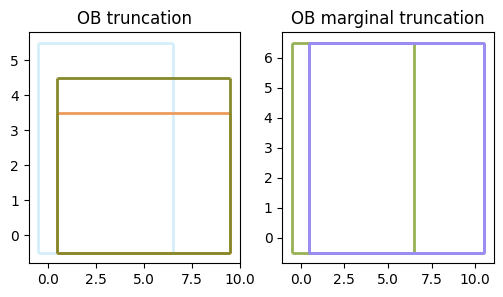

100%|██████████| 3/3 [00:00<00:00, 10.93it/s]


In [43]:
data.compute_moments(tqdm_disable=False)
data.compute_probabilities(display=True, tqdm_disable=False)
data.compute_fm(tqdm_disable=False)

## Single sample feasibility

For each sample $x_{1}$, $x_{2}$, $x_{3}$ use marginal probability and CME to test feasibility of birth-death model

In [44]:
constraints = [
    "marginal_probability_1",
    "marginal_CME_1",
    "k_deg_1"
]

print("X1, X1, X2")

single_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

constraints = [
    "marginal_probability_2",
    "marginal_CME_2",
    "k_deg_2"
]

print("X2, X3, X3")

single_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

X1, X1, X2
Optimization status: INFEASIBLE
Runtime: 0.0009999275207519531
Optimization status: INFEASIBLE
Runtime: 0.0010001659393310547
Optimization status: INFEASIBLE
Runtime: 0.0
X2, X3, X3
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.003000020980834961
Optimization status: OPTIMAL
Runtime: 0.003000020980834961


Birth death feasibility tests correctly identify that $X_{1}$ and $X_{2}$ do not follow a birth-death model (INFEASIBLE) but $X_{3}$ does (OPTIMAL)

## Independent pair feasibility

In [45]:
constraints = [
    "marginal_probability_1",
    "marginal_probability_2",
    "marginal_CME_1",
    "marginal_CME_2",
    "k_deg_1",
    "k_deg_2"
]


print("(X1, X2), (X1, X3), (X2, X3)")

pair_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

(X1, X2), (X1, X3), (X2, X3)
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.003000020980834961
Optimization status: INFEASIBLE
Runtime: 0.0


Using marginal constraints produces identical results to AND operation on single sample tests (as this is what is happening in constraints)

In [50]:
constraints = [
    "probability",
    "CME",
    "factorization",
    "k_reg",
    "k_deg_1",
    "k_deg_2"
]


print("(X1, X2), (X1, X3), (X2, X3)")

pair_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

(X1, X2), (X1, X3), (X2, X3)
Optimization status: INFEASIBLE
Runtime: 0.0009999275207519531
Optimization status: INFEASIBLE
Runtime: 0.6469998359680176
Optimization status: INFEASIBLE
Runtime: 0.8409998416900635


Using joint constraints (with independence assumption) also produces the same results, But, perhaps only for sufficiently high interaction strength as generally joint constraints are weaker.

Overall the independent birth-death feasibility tests show that if **at least one** sample in the pair is affected by sufficiently high interaction then the model is infeasible. 

## Interacting pair feasibility

In [51]:
constraints = [
    "joint_probability",
    "CME",
    "k_deg_1"
]

print("(X1, X2), (X1, X3), (X2, X3)")

pair_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

(X1, X2), (X1, X3), (X2, X3)
Optimization status: OPTIMAL
Runtime: 0.019999980926513672
Optimization status: OPTIMAL
Runtime: 0.8300001621246338
Optimization status: OPTIMAL
Runtime: 0.8589999675750732


Interacting birth-death feasibility test is feasible for all pairs.

This is expected for $(X_{1}, X_{2})$ as these truly follow an interacting birth death model, but for the pairs $(X_{1}, X_{3})$ and $(X_{2}, X_{3})$ only one the samples is affected by interaction: either the constraints are too weak to identify this, or the model is simply general enough that these pairs are still consistent with it.

## Moment test

In [52]:
constraints = [
    "dummy_moment"
]

print("(X1, X2), (X1, X3), (X2, X3)")

pair_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

(X1, X2), (X1, X3), (X2, X3)
Optimization status: INFEASIBLE
Runtime: 0.0010001659393310547
Optimization status: OPTIMAL
Runtime: 0.003999948501586914
Optimization status: OPTIMAL
Runtime: 0.00599980354309082


Moments correctly identify the interaction present in the 1st pair and lack of in the 2nd and 3rd pairs, even though these pairs have one sample affected by strong interaction.

## Correlation test

In [54]:
corr = correlation.Correlation(data, tqdm_disable=True)

sample 0 p-value: 9.994851629150251e-47
sample 1 p-value: 0.5556251284148317
sample 2 p-value: 0.8163599256374103


Correlation test performs the same as the moments, correctly classifying the pairs